In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from hpe_library.lib_import import *
from hpe_library. my_utils import *
os.chdir(f'/home/{user}/codes/MotionBERT')
import scipy.io

root_3dhp = f'/home/{user}/Datasets/HAAI/3DHP'
source = 'original' # 
root_original = os.path.join(root_3dhp, source)
train_folder = os.path.join(root_original, 'train')
test_folder = os.path.join(root_original, 'test')

In [2]:
data_dict = {}

# get train data
for subject in tqdm(natsorted(os.listdir(train_folder))):
    for seq in natsorted(os.listdir(os.path.join(train_folder, subject))):
        #print(subject, seq)
        data = scipy.io.loadmat(os.path.join(train_folder, subject, seq, 'annot.mat'))
        #print(data.keys())
        
        for cam_num in range(14):
            source = '_'.join([subject, seq, f'cam{cam_num}'])
            data_dict[source] = {}
            anoot2 = mpi_inf_3dhp2h36m(np.array(data['annot2'][cam_num][0].reshape(-1, 28, 2)).copy())
            annot3 = mpi_inf_3dhp2h36m(np.array(data['annot3'][cam_num][0].reshape(-1, 28, 3)).copy())
            univ_annot3 = np.array(data['univ_annot3'][cam_num][0].copy().reshape(-1, 28, 3))
            # get valid frame
            w_over_range = (anoot2[:, :, 0] > 2048) | (anoot2[:, :, 0] < 0)
            h_over_range = (anoot2[:, :, 1] > 2048) | (anoot2[:, :, 1] < 0)
            over_range = np.logical_or(w_over_range, h_over_range)
            valid_frame = np.logical_not(np.any(over_range, axis=1))
            num_visible_frames = len(np.where(valid_frame == True)[0])
            #print(f'{source} total_frame: {len(anoot2)} valid_frame: {num_visible_frames}')
            
            data_dict[source]['annot2'] = anoot2
            data_dict[source]['annot3'] = annot3
            data_dict[source]['univ_annot3'] = univ_annot3
            data_dict[source]['valid_frame'] = valid_frame
            data_dict[source]['num_visible_frames'] = num_visible_frames
            #print(anoot2.shape, annot3.shape, univ_annot3.shape)
            #break
        #break
    #break


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


### Calculate scale factor (train)

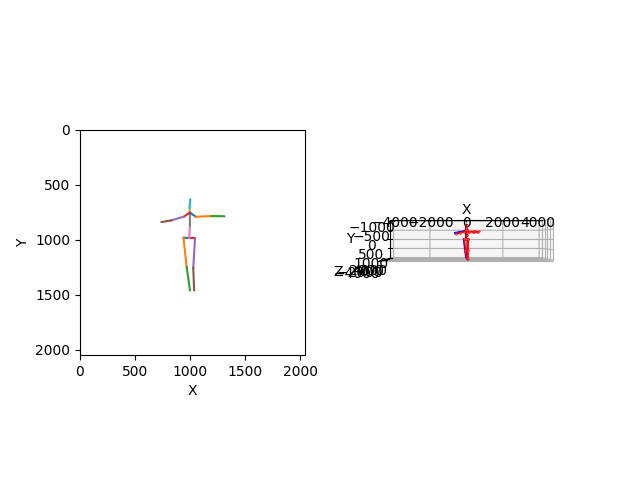

In [3]:
source = 'S1_Seq1_cam5'
subject, seq, cam_num = source.split('_')
#cam_num = cam_num[-1]
cam_param = readpkl(f'/home/{user}/codes/MotionBERT/custom_codes/dataset_generation/3dhp/3dhp_train_cam_params.pkl')

R = cam_param[cam_num]['R']
t = cam_param[cam_num]['t']
C = cam_param[cam_num]['C']
intrinsic = cam_param[str(cam_num)]['intrinsic']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]

frame_num = 0
visible_frame = data_dict[source]['visible_frame']
num_visible_frames = data_dict[source]['num_visible_frames']
img_2d_gt = data_dict[source]['annot2'][visible_frame][frame_num]
# canonical
# img_2d_gt -= img_2d_gt[0]
# scale = np.linalg.norm(img_2d_gt.reshape(1, -1), ord=2, axis=1, keepdims=True) # (17, 1)
# print(scale)
# img_2d_gt /= scale

cam_3d = data_dict[source]['annot3'][visible_frame]
cam_3d_hat = get_rootrel_pose(cam_3d)

cam_3d_from_canonical_3d = cam_3d.copy()
cam_3d_from_canonical_3d[...,:2] -= cam_3d[:, 0:1, :2]
img_2d_from_canonical_3d = np.einsum('ij,jkl->ikl', intrinsic, cam_3d_from_canonical_3d.T).T
img_2d_from_canonical_3d = img_2d_from_canonical_3d / img_2d_from_canonical_3d[..., 2:3]

box = infer_box(cam_3d[frame_num], {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
img_2d, img_3d = camera_to_image_frame(cam_3d[frame_num], box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

# 2.5d factor
pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat[frame_num], stop_tolerance=0.0001) # x,y,z 사용

H, W = 2048, 2048
fig = plt.figure(3)
fig.clear()
ax = axes_2d(fig, loc=121, H=H, W=W)
ax_cam = axes_3d(fig, loc=122, view=(-90,-90), xlim=(-4000, 4000), ylim=(-1000, 1000), zlim=(-4000, 4000))
draw_2d_pose(ax, img_2d_gt, H=H, W=W)

draw_3d_pose(ax_cam, cam_3d[frame_num])
draw_3d_pose(ax_cam, cam_3d_hat[frame_num])
draw_3d_pose(ax_cam, img_3d_hat*pred_lambda, color='r')
plt.show()

In [12]:
cam_3d.shape

(17, 3)

### train pkl

In [10]:
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/3dhp_gt_train_canonical_3d_same_z_pkl'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    
pass_cam = [] # [0, 1, 2, 4, 5, 6, 7, 8]
cam_params = readpkl(f'/home/{user}/codes/MotionBERT/custom_codes/dataset_generation/3dhp/3dhp_train_cam_params.pkl')


for subject in natsorted(os.listdir(train_folder)):
    for seq in natsorted(os.listdir(os.path.join(train_folder, subject))):
        for cam_num in range(14):
            if len(pass_cam) > 0:
                if cam_num not in pass_cam: continue
            source = '_'.join([subject, seq, f'cam{cam_num}'])
            file_name = source + '.pkl'
            save_path = os.path.join(save_folder, file_name)
            if os.path.exists(save_path):
                print(f'{file_name} already exists')
                continue
            
            data = {}
            for key in ['joint_2d', 'joint_2d_from_canonical_3d', 'confidence', 'joint3d_image', 'camera_name', 'action', 'source', 'frame', 'cam_3d', 'cam_3d_from_canonical_3d', 'cam_param']:
                data[key] = []
                
            cam_param = cam_params[f'cam{cam_num}']
            R = cam_param['R']
            t = cam_param['t']
            C = cam_param['C']
            intrinsic = cam_param['intrinsic']
            fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
            
            action = source
            camera_id = cam_num

            visible_frame = data_dict[source]['visible_frame']
            num_visible_frames = data_dict[source]['num_visible_frames']
            
            cam_3d = data_dict[source]['annot3'][visible_frame]
            
            cam_3d_hat = get_rootrel_pose(cam_3d)

            cam_3d_from_canonical_3d = cam_3d.copy()
            cam_3d_from_canonical_3d[...,:2] -= cam_3d[:, 0:1, :2]
            img_2d_from_canonical_3d = np.einsum('ij,jkl->ikl', intrinsic, cam_3d_from_canonical_3d.T).T
            img_2d_from_canonical_3d = img_2d_from_canonical_3d / img_2d_from_canonical_3d[..., 2:3]
            
            pbar = tqdm(range(num_visible_frames))
                        
            for frame_num in pbar:
                box = infer_box(cam_3d[frame_num], {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
                img_2d, img_3d = camera_to_image_frame(cam_3d[frame_num], box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
                img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

                # 2.5d factor
                #pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat[frame_num], stop_tolerance=0.0001) # x,y,z 사용
                
                # joint 2.5d image
                #img_25d = img_3d * pred_lambda

                # store
                data['joint_2d'].append(np.array(img_2d).copy()) 
                data['joint_2d_from_canonical_3d'].append(np.array(img_2d_from_canonical_3d[frame_num]).copy())
                data['confidence'].append(np.ones(17)) 
                data['joint3d_image'].append(np.array(img_3d).copy()) 
                #data['joints_2.5d_image'].append(np.array(img_25d).copy()) 
                #data['2.5d_factor'].append(np.array(pred_lambda).copy()) 
                data['camera_name'].append(np.array(camera_id).copy()) 
                data['action'].append(np.array(action).copy()) 
                data['source'].append(np.array(source).copy()) 
                data['frame'].append(np.array(frame_num).copy()) 
                data['cam_3d'].append(np.array(cam_3d[frame_num]).copy()) 
                data['cam_3d_from_canonical_3d'].append(np.array(cam_3d_from_canonical_3d[frame_num]).copy())
                
                pbar.postfix = f'{source} frame: {frame_num}'

            savepkl(data, save_path)
    #         break
    #     break
    # break

S1_Seq1_cam0.pkl already exists


100%|██████████| 5043/5043 [00:00<00:00, 23097.97it/s, S8_Seq2_cam13 frame: 5042]
